# Python Implementation of CAVI
### Source : https://zhiyzuo.github.io/VI/

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K

# Making data

In [59]:
num_components = 3
mu_arr = np.random.choice(np.arange(-10, 10, 2),
                          num_components) +\
         np.random.random(num_components)
mu_arr

array([-7.97469581, -3.75093274,  0.91318769])

In [60]:
SAMPLE = 1000

In [61]:
X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))

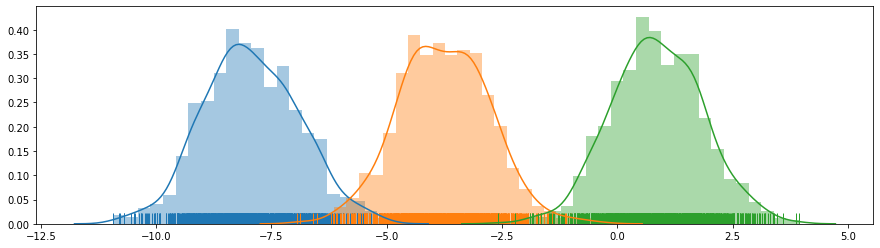

In [62]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)


# Fitting

In [63]:
ugmm = UGMM(X, 3)
ugmm.fit()

Init mean
[ 3.21503886 -2.26682356 -3.35956599]
Init s2
[0.57924817 0.68675389 0.63222455]
5 [ 0.87530596 -3.71442832 -7.90224791]
10 [ 0.85569411 -3.78549571 -7.95482678]
15 [ 0.85563529 -3.78569126 -7.9549583 ]
20 [ 0.85563513 -3.78569179 -7.95495865]
25 [ 0.85563513 -3.78569179 -7.95495866]
ELBO converged with ll -1357.191 at iteration 25


In [64]:
ugmm.phi.argmax(1)

array([2, 2, 2, ..., 0, 0, 0])

In [65]:
sorted(mu_arr)

[-7.974695807814452, -3.7509327376156048, 0.9131876904435512]

In [66]:
sorted(ugmm.m)

[-7.95495865583895, -3.7856917903033125, 0.8556351286919307]

# Result

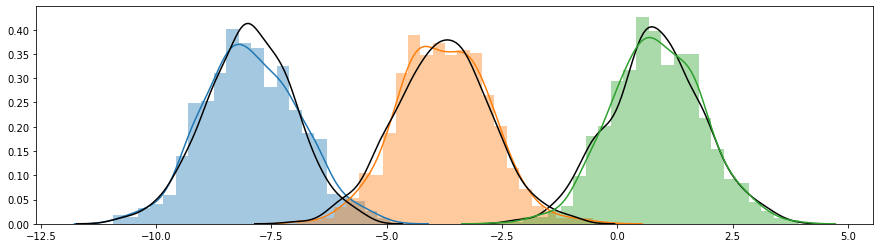

In [67]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[0], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[1], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[2], 1, SAMPLE), color='k', hist=False, kde=True)